Rebuilding Wikipedia classification corpus...
Corpus saved: 15 disciplines

Processing JOCS...
JOCS: 2026 papers classified
predicted_discipline
Modeling & simulation                411
Algorithm & Data structures          362
Machine learning                     204
Parallel, distributed computing      200
Information system & Data science    165
Name: count, dtype: int64

Processing ICCS...
ICCS: 8182 papers classified
predicted_discipline
Algorithm & Data structures          1551
Modeling & simulation                1388
Parallel, distributed computing       884
Machine learning                      684
Information system & Data science     647
Name: count, dtype: int64


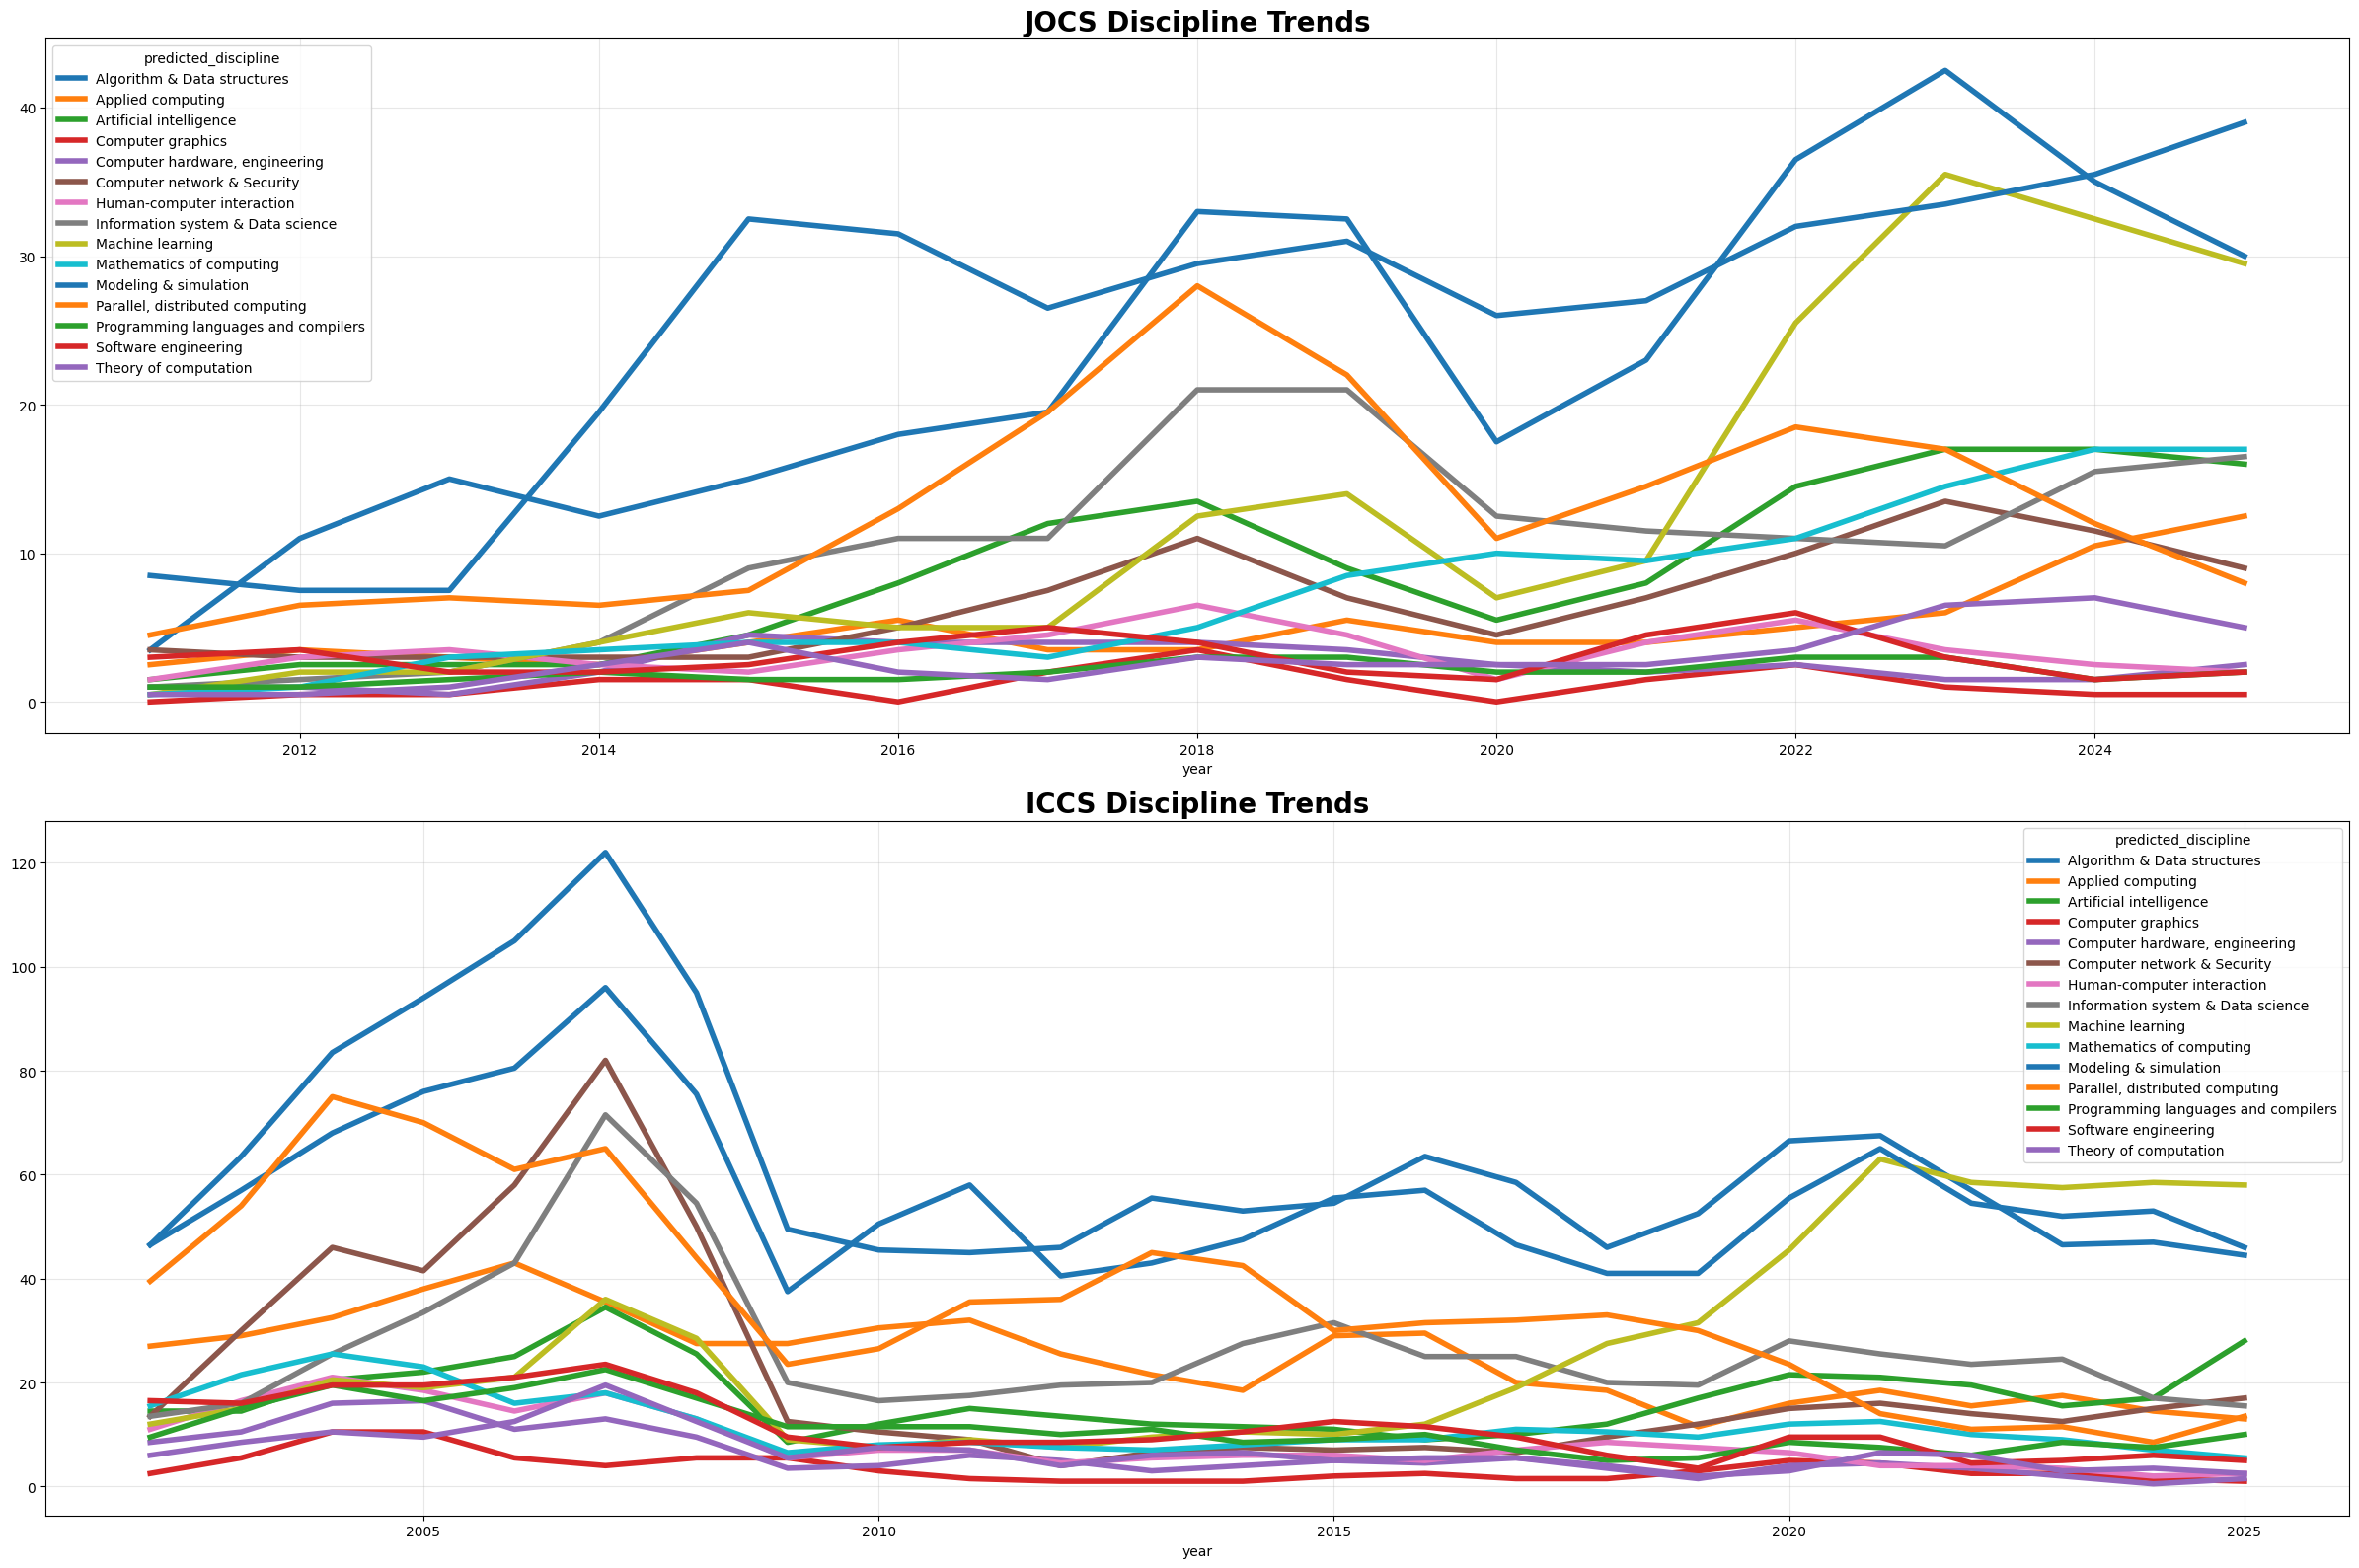

Complete analysis saved.


In [ ]:
import pandas as pd
import numpy as np
import wikipediaapi
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)


# CLASSIFICATION CORPUS
def clean_wiki_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())
    words = [lemmatizer.lemmatize(w) for w in text.split() 
             if w not in stop_words and len(w) > 2]
    return ' '.join(words)

topics_map = {
    "Algorithm & Data structures": ["Algorithm", "Data structure"],
    "Applied computing": ["Computational science", "Scientific computing"],
    "Artificial intelligence": ["Artificial intelligence"],
    "Computer graphics": ["Computer graphics"],
    "Computer hardware, engineering": ["Computer hardware", "Computer engineering"],
    "Computer network & Security": ["Computer network", "Computer security"],
    "Human-computer interaction": ["Human–computer interaction"],
    "Information system & Data science": ["Information system", "Data science"],
    "Machine learning": ["Machine learning"],
    "Mathematics of computing": ["Discrete mathematics", "Numerical analysis"],
    "Modeling & simulation": ["Scientific modeling", "Computer simulation"],
    "Parallel, distributed computing": ["Parallel computing", "Distributed computing"],
    "Programming languages and compilers": ["Programming language", "Compiler"],
    "Software engineering": ["Software engineering"],
    "Theory of computation": ["Theory of computation"]
}

wiki = wikipediaapi.Wikipedia(user_agent='ITMO_Project/1.0', language='en')
corpus_data = []

print("Rebuilding Wikipedia classification corpus...")
for category, pages in topics_map.items():
    combined_text = ""
    for page_title in pages:
        page = wiki.page(page_title)
        if page.exists():
            combined_text += page.summary + " " + page.text[:2000]
    cleaned_text = clean_wiki_text(combined_text)
    corpus_data.append({'discipline': category, 'reference_text': cleaned_text})
    time.sleep(1)

corpus_df = pd.DataFrame(corpus_data)
corpus_df.to_csv("classification_corpus.csv", index=False)
print(f"Corpus saved: {len(corpus_df)} disciplines")


# DATASETS
datasets = {
    "JOCS": r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\jocs_analysis\jocs_master_dataset.csv",
    "ICCS": r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\iccs_analysis\iccs_master_dataset.csv"
}

results = {}
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2))

for name, path in datasets.items():
    print(f"\nProcessing {name}...")
    df = pd.read_csv(path)
    
    # Use abstract (or cleaned if available)
    text_col = 'cleaned_abstract' if 'cleaned_abstract' in df.columns else 'abstract'
    df[text_col] = df[text_col].fillna("").astype(str)
    
    # TF-IDF
    all_text = pd.concat([corpus_df['reference_text'], df[text_col]])
    vectorizer.fit(all_text)
    corpus_tfidf = vectorizer.transform(corpus_df['reference_text'])
    papers_tfidf = vectorizer.transform(df[text_col])
    
    # Classify
    similarities = cosine_similarity(papers_tfidf, corpus_tfidf)
    df['predicted_discipline'] = corpus_df['discipline'].iloc[similarities.argmax(axis=1)].values
    df['sim_score'] = similarities.max(axis=1)
    
    results[name] = df
    df.to_csv(f"{name.lower()}_classified.csv", index=False)
    print(f"{name}: {len(df)} papers classified")
    print(df['predicted_discipline'].value_counts().head())


# TREND COMPARISON
fig, axes = plt.subplots(2, 1, figsize=(24, 16))
for i, (name, df) in enumerate(results.items()):
    trends = df.groupby(['year', 'predicted_discipline']).size().unstack(fill_value=0)
    trends_smooth = trends.rolling(window=2, center=True).mean()
    trends_smooth.plot(ax=axes[i], linewidth=4)
    axes[i].set_title(f"{name} Discipline Trends", fontsize=20, fontweight='bold')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("iccs_jocs_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("Complete analysis saved.")


N=20


N=20 Classification: JOCS
Processing 2026 JOCS papers
Top 5 disciplines (N=20):
predicted_discipline_n20
Modeling & simulation                411
Algorithm & Data structures          362
Machine learning                     204
Parallel, distributed computing      200
Information system & Data science    165
Name: count, dtype: int64
Mean top score: 0.067

N=20 Classification: ICCS
Processing 8182 ICCS papers
Top 5 disciplines (N=20):
predicted_discipline_n20
Algorithm & Data structures          1551
Modeling & simulation                1388
Parallel, distributed computing       884
Machine learning                      684
Information system & Data science     647
Name: count, dtype: int64
Mean top score: 0.078

STANDARDIZED POPULARITY SCORES (Eq 4)
JOCS popularity scores saved
JOCS top disciplines (popularity):
Parallel, distributed computing      3.682875
Modeling & simulation                3.606236
Algorithm & Data structures          3.561048
Applied computing                   

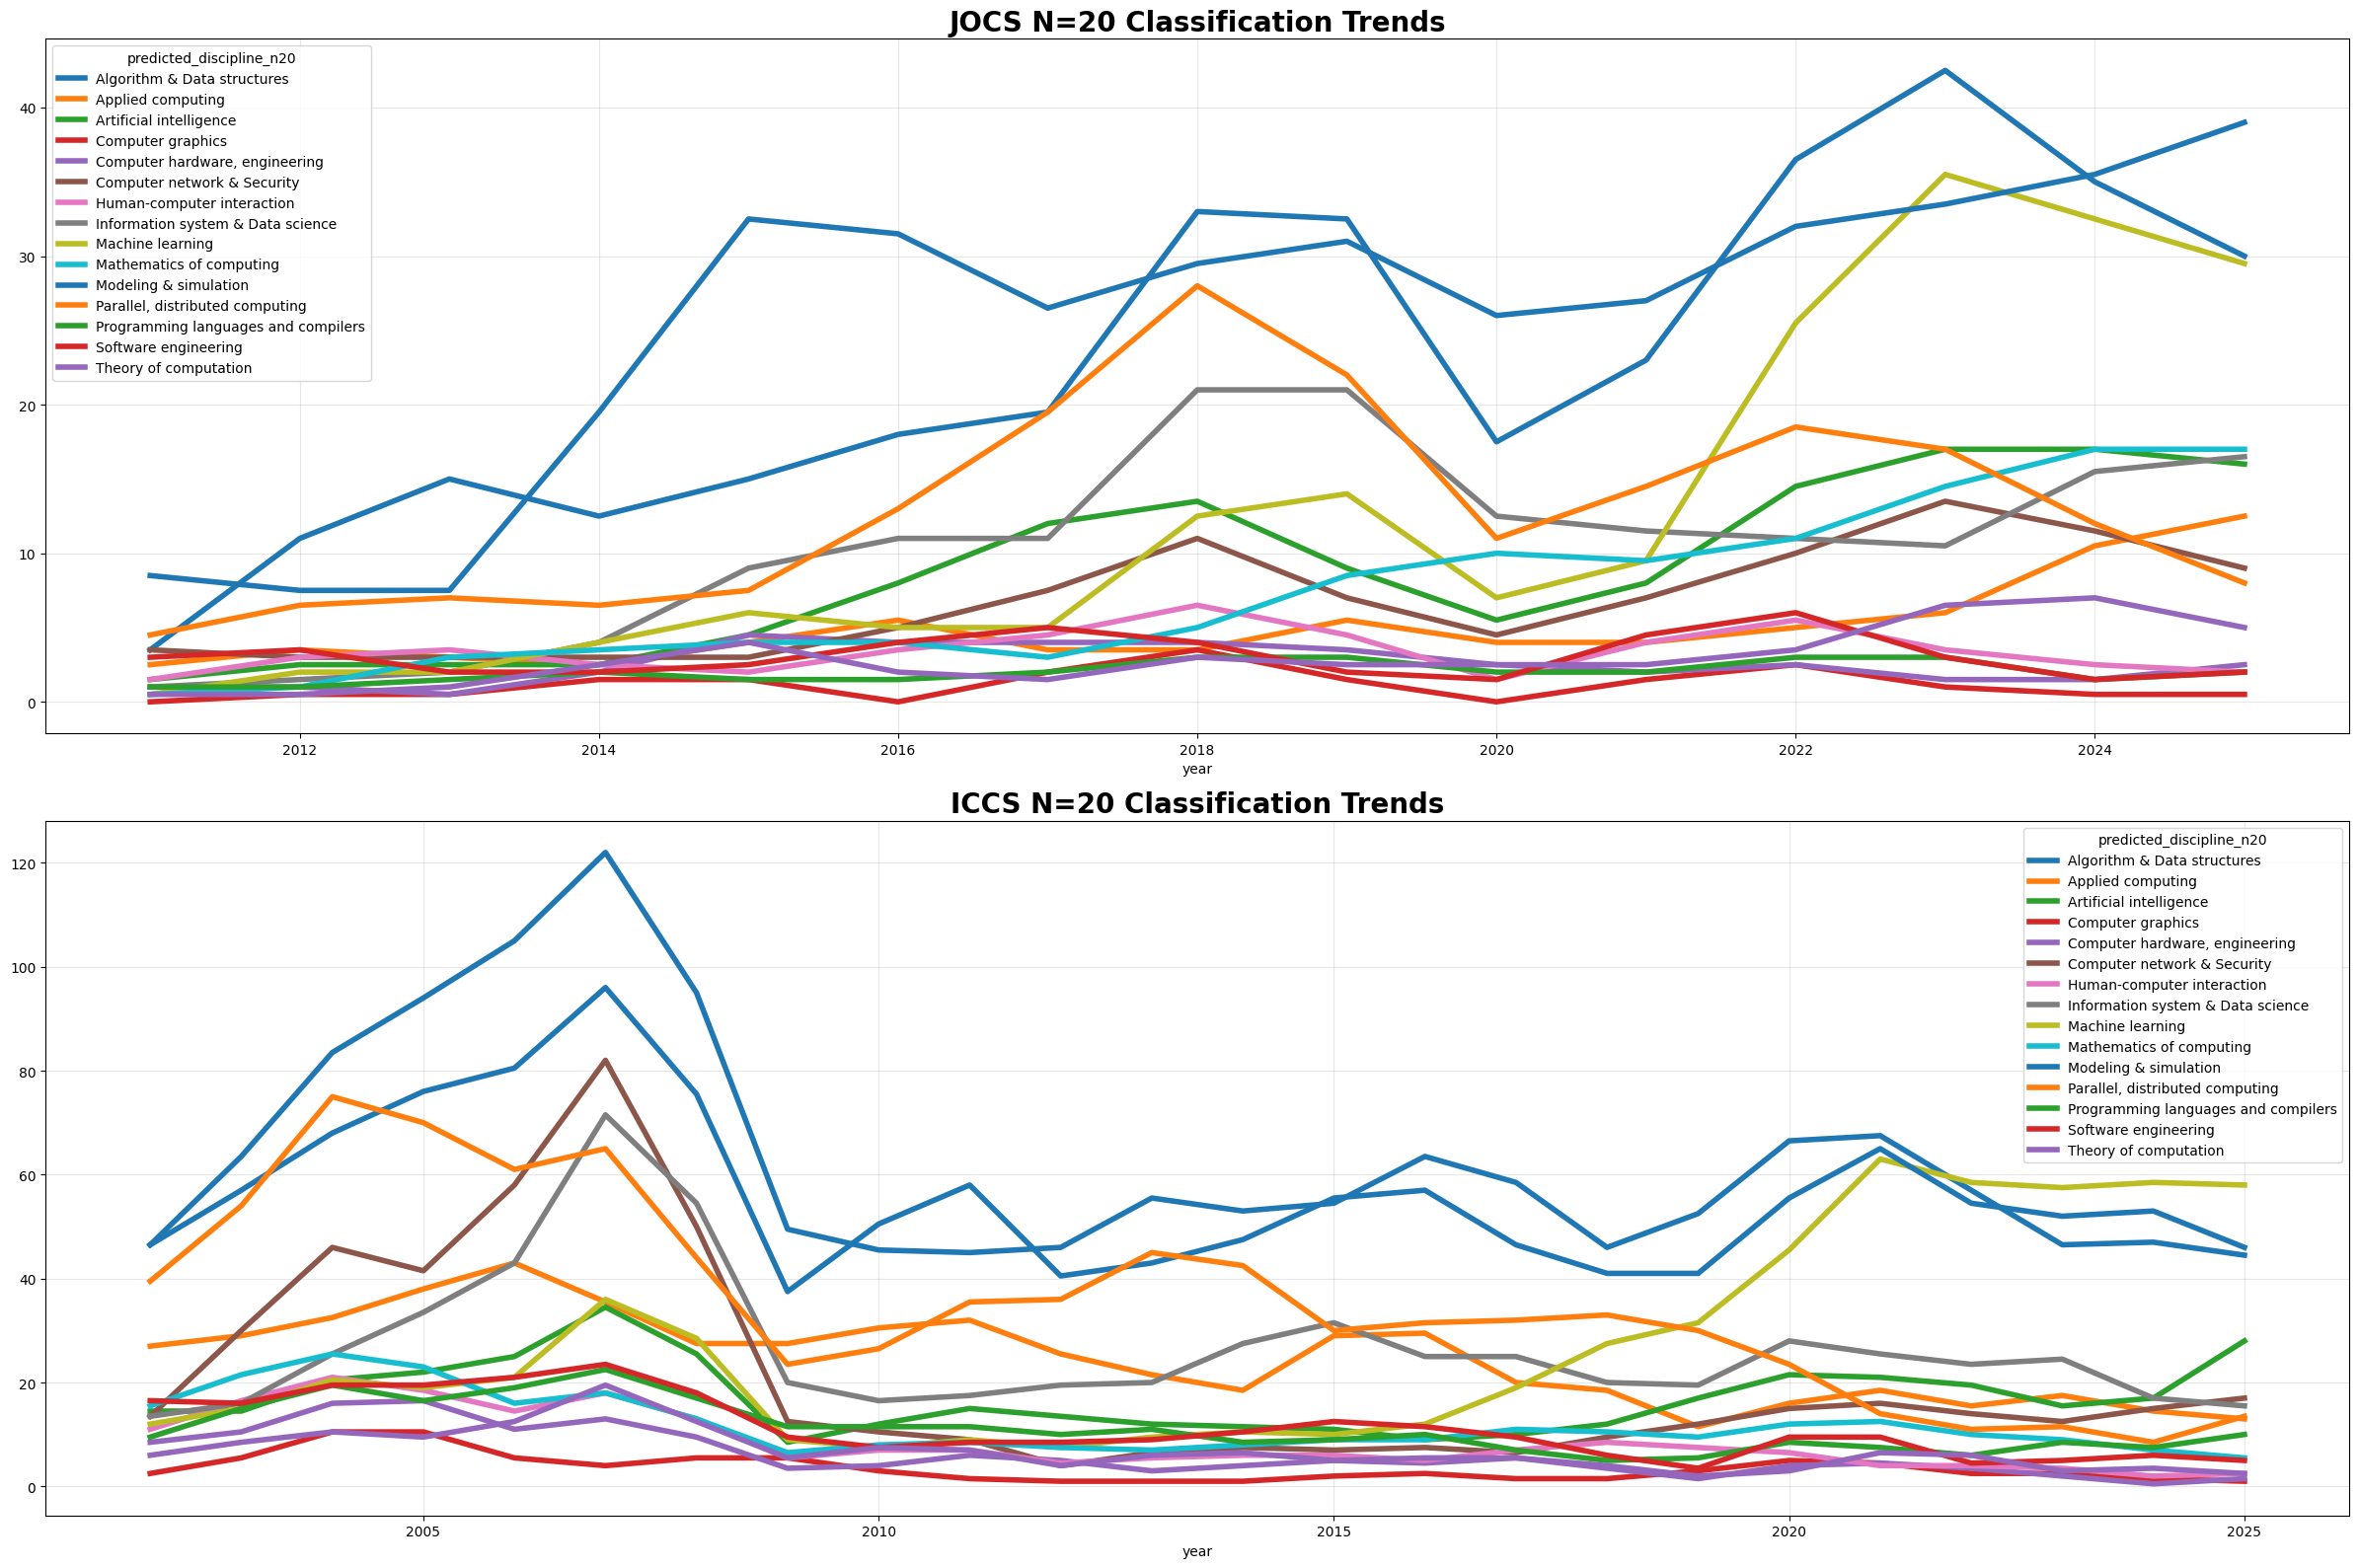


Complete N=20 analysis saved.


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load datasets
corpus_df = pd.read_csv(r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\previous_experiments\classification_corpus.csv")
corpus_df['reference_text'] = corpus_df['reference_text'].fillna("").astype(str)

datasets = {
    "JOCS": r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\jocs_analysis\jocs_master_dataset.csv",
    "ICCS": r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\iccs_analysis\iccs_master_dataset.csv"
}

# N=20 FILTERING FUNCTION
def apply_n20_filtering(similarity_matrix, n=20):
    """
    Paper's N=20 filtering [file:1]:
    - Keep top N similarities per paper
    - Set rest to 0
    """
    n20_matrix = np.zeros_like(similarity_matrix)
    for i in range(similarity_matrix.shape[0]):
        top_indices = np.argsort(similarity_matrix[i])[-n:]
        n20_matrix[i, top_indices] = similarity_matrix[i, top_indices]
    return n20_matrix

results = {}

for name, path in datasets.items():
    print(f"\n{'='*50}")
    print(f"N=20 Classification: {name}")
    
    df = pd.read_csv(path)
    text_col = 'cleaned_abstract' if 'cleaned_abstract' in df.columns else 'abstract'
    df[text_col] = df[text_col].fillna("").astype(str)
    
    print(f"Processing {len(df)} {name} papers")
    
    # TF-IDF
    all_text = pd.concat([corpus_df['reference_text'], df[text_col]])
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2))
    vectorizer.fit(all_text)
    
    corpus_tfidf = vectorizer.transform(corpus_df['reference_text'])
    papers_tfidf = vectorizer.transform(df[text_col])
    
    # Original similarity
    similarities = cosine_similarity(papers_tfidf, corpus_tfidf)
    
    # N=20 FILTERING (Paper method)
    similarities_n20 = apply_n20_filtering(similarities, n=20)
    
    # Primary discipline (highest score after N=20)
    primary_indices = similarities_n20.argmax(axis=1)
    df['predicted_discipline_n20'] = corpus_df['discipline'].iloc[primary_indices].values
    df['top_similarity_n20'] = similarities_n20.max(axis=1)
    
    # Save top 20 scores for each paper (full replication)
    top20_scores = []
    for i in range(len(df)):
        top20_idx = np.argsort(similarities_n20[i])[-20:][::-1]
        top20_scores.append({
            'paper_id': i,
            'top20_disciplines': corpus_df['discipline'].iloc[top20_idx].tolist(),
            'top20_scores': similarities_n20[i, top20_idx].tolist()
        })
    df['top20_details'] = [str(top20_scores[i]) for i in range(len(df))]
    
    # Save
    df.to_csv(f"{name.lower()}_n20_classified.csv", index=False)
    results[name] = df
    
    print("Top 5 disciplines (N=20):")
    print(df['predicted_discipline_n20'].value_counts().head())
    print(f"Mean top score: {df['top_similarity_n20'].mean():.3f}")

# =============================================================================
# POPULARITY SCORES (Paper Eq 4)
# =============================================================================
print("\n" + "="*60)
print("STANDARDIZED POPULARITY SCORES (Eq 4)")

for name, df in results.items():
    yearly_popularity = {}
    
    for year in df['year'].unique():
        year_papers = df[df['year'] == year]
        n_papers = len(year_papers)
        
        year_sim_n20 = similarities_n20[year_papers.index]  # Corresponding rows
        
        # Eq 4: sum(similarities) / n_papers * 100
        discipline_popularity = (year_sim_n20.sum(axis=0) / n_papers) * 100
        yearly_popularity[year] = dict(zip(corpus_df['discipline'], discipline_popularity))
    
    popularity_df = pd.DataFrame(yearly_popularity).T
    popularity_df.to_csv(f"{name.lower()}_popularity_scores_eq4.csv")
    print(f"{name} popularity scores saved")
    
    print(f"{name} top disciplines (popularity):")
    print(popularity_df.mean().sort_values(ascending=False).head())

# =============================================================================
# TREND PLOTS WITH N=20 (Fig 1 style)
# =============================================================================
fig, axes = plt.subplots(2, 1, figsize=(24, 16))

for i, (name, df) in enumerate(results.items()):
    yearly_counts = df.groupby(['year', 'predicted_discipline_n20']).size().unstack(fill_value=0)
    yearly_smooth = yearly_counts.rolling(window=2, center=True).mean()
    
    yearly_smooth.plot(ax=axes[i], linewidth=4)
    axes[i].set_title(f"{name} N=20 Classification Trends", fontsize=20, fontweight='bold')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("n20_classification_trends.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nComplete N=20 analysis saved.")


In [5]:
import pandas as pd
import numpy as np

def calculate_magnitude_change(popularity_csv, output_name, start_year=None):
    """
    Replicates Fig 3 & 4 analysis:
    - Ranks second-level disciplines by absolute increase (Rising).
    - Ranks by percentage decrease (Falling).
    """
    # Load the standardized popularity scores (Eq 4 output)
    df = pd.read_csv(popularity_csv, index_col=0)
    
    # Sort years to ensure we get the first and last correctly
    years = sorted(df.index.tolist())
    base_yr = start_year if start_year in years else years[0]
    latest_yr = years[-1]
    
    print(f"\nAnalyzing {output_name}: {base_yr} to {latest_yr}")
    
    # Calculate Absolute Magnitude Change (Latest - Base)
    magnitude_change = df.loc[latest_yr] - df.loc[base_yr]
    
    # Calculate Percentage Change for declining topics
    # Handle division by zero or very small base values
    percent_change = ((df.loc[latest_yr] - df.loc[base_yr]) / df.loc[base_yr].replace(0, np.nan)) * 100
    
    # 1. Top 10 RISING (Highest Absolute Increase) - Fig 3 Style
    rising = magnitude_change.sort_values(ascending=False).head(10)
    
    # 2. Top 10 FALLING (Highest Percentage Decrease) - Fig 4 Style
    # We filter for things that actually decreased (change < 0)
    falling_magnitude = magnitude_change[magnitude_change < 0].sort_values(ascending=True).head(10)
    falling_percent = percent_change[magnitude_change < 0].sort_values(ascending=True).head(10)
    
    # 3. Top 20 Current Dominance (Latest Year Rank) - Table 4/5 Style
    top_current = df.loc[latest_yr].sort_values(ascending=False).head(20)
    
    # Save Results
    rising.to_csv(f"{output_name}_rising_topics.csv")
    falling_percent.to_csv(f"{output_name}_falling_topics_percent.csv")
    top_current.to_csv(f"{output_name}_top_20_{latest_yr}.csv")
    
    return rising, falling_percent, top_current

# =============================================================================
# RUN ANALYSIS
# =============================================================================

# JOCS Analysis (Baseline 2010)
jocs_rising, jocs_falling, jocs_top = calculate_magnitude_change(
    "jocs_popularity_scores_eq4.csv", "JOCS", start_year=2010
)

# ICCS Analysis (Baseline 2001)
iccs_rising, iccs_falling, iccs_top = calculate_magnitude_change(
    "iccs_popularity_scores_eq4.csv", "ICCS", start_year=2001
)

# Print Summary for Verification
print("\n" + "="*40)
print("VERIFICATION SUMMARY (2025 UPDATES)")
print("="*40)
print(f"JOCS Top Rising Topic: {jocs_rising.index[0]} (+{jocs_rising.values[0]:.2f})")
print(f"ICCS Top Rising Topic: {iccs_rising.index[0]} (+{iccs_rising.values[0]:.2f})")
print("\nTop 5 Current JOCS (2025):")
print(jocs_top.head(10))


Analyzing JOCS: 2010 to 2025.0

Analyzing ICCS: 2001 to 2025.0

VERIFICATION SUMMARY (2025 UPDATES)
JOCS Top Rising Topic: Computer network & Security (+1.02)
ICCS Top Rising Topic: Machine learning (+1.89)

Top 5 Current JOCS (2025):
Parallel, distributed computing      3.653005
Modeling & simulation                3.487368
Algorithm & Data structures          3.412557
Computer network & Security          3.062656
Applied computing                    2.986280
Information system & Data science    2.814331
Artificial intelligence              2.424236
Machine learning                     2.159157
Computer hardware, engineering       1.977239
Theory of computation                1.840105
Name: 2025.0, dtype: float64


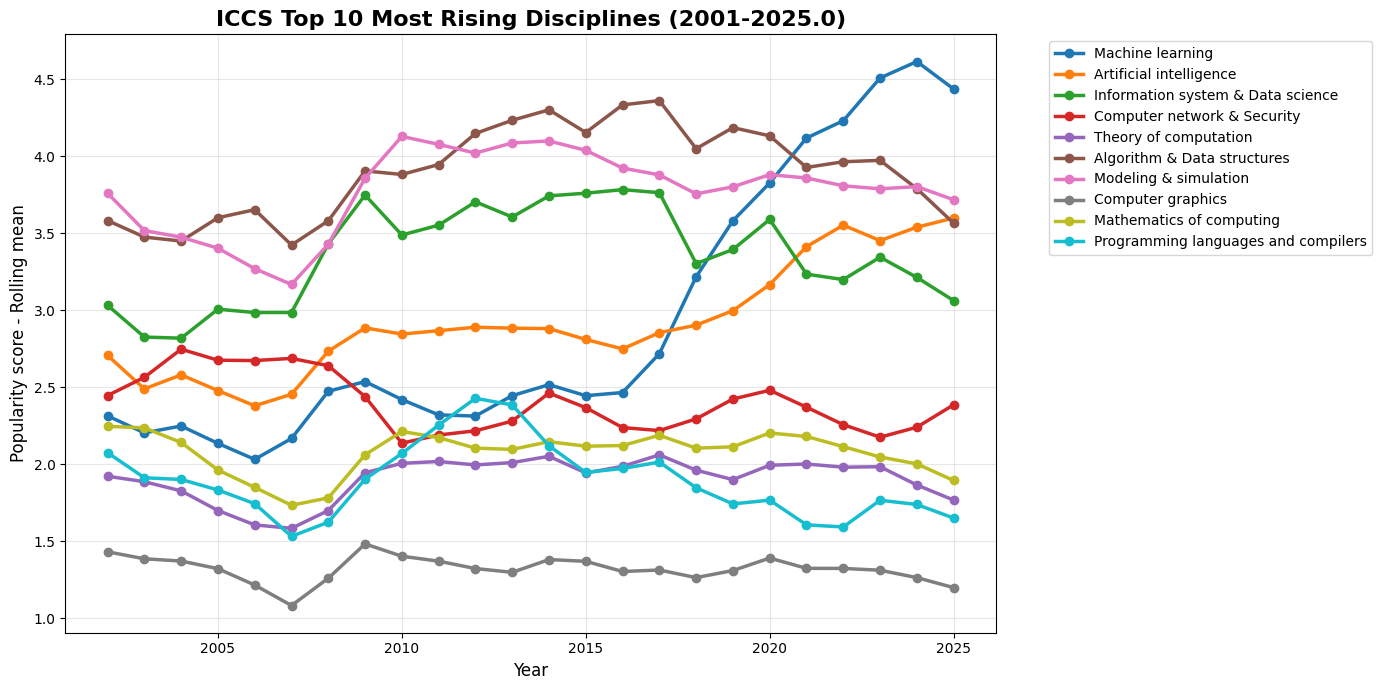

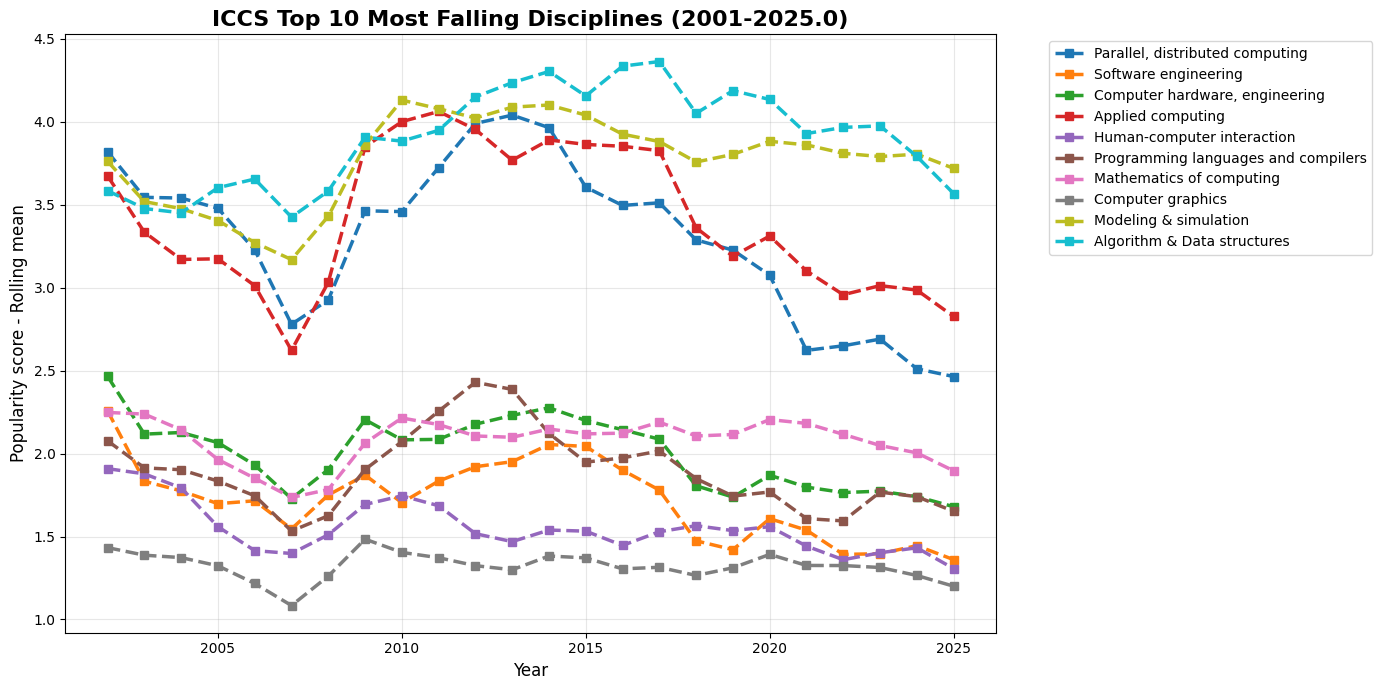

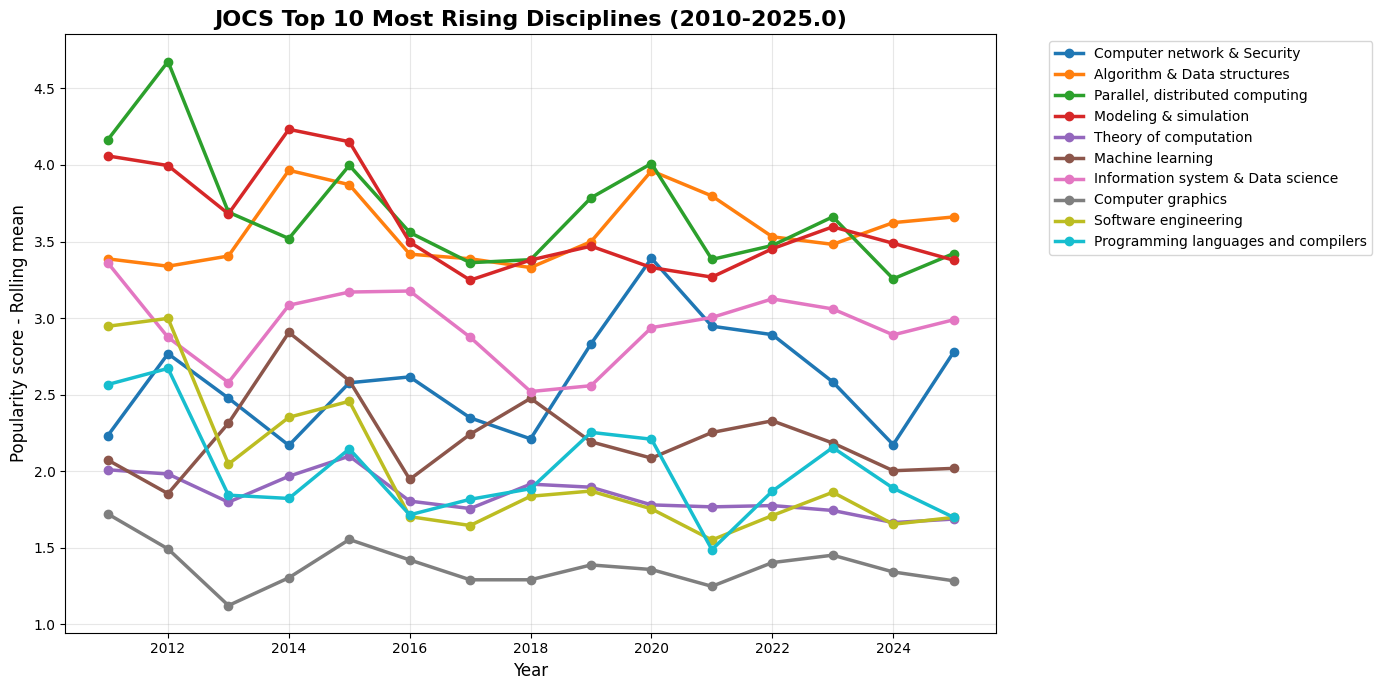

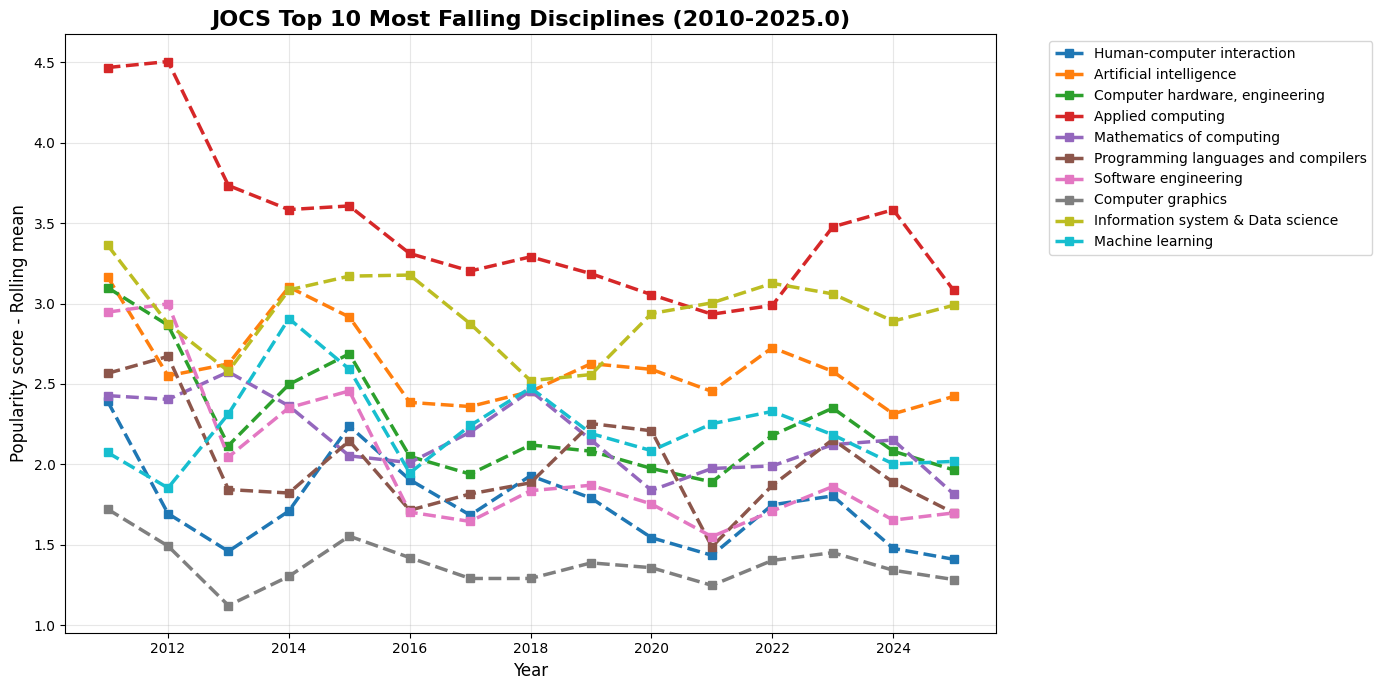

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_rising_falling_trends(popularity_csv, title_prefix, start_year=None):
    """
    Plots Top 10 Rising and Falling trends matching the paper's style.
    """
    # 1. Load Data
    df = pd.read_csv(popularity_csv, index_col=0)
    years = sorted(df.index.tolist())
    base_yr = start_year if start_year in years else years[0]
    latest_yr = years[-1]
    
    # 2. Identify Top 10 Rising & Falling
    change = df.loc[latest_yr] - df.loc[base_yr]
    top_rising = change.sort_values(ascending=False).head(10).index
    top_falling = change.sort_values(ascending=True).head(10).index

    # 3. Apply Rolling Mean (Window=2) as per Paper Eq
    df_smooth = df.rolling(window=2, center=True).mean()

    # 4. Plot Rising Trends (Fig 3 & 7 Style)
    plt.figure(figsize=(14, 7))
    for col in top_rising:
        plt.plot(df.index, df_smooth[col], marker='o', linewidth=2.5, label=col)
    
    plt.title(f"{title_prefix} Top 10 Most Rising Disciplines ({base_yr}-{latest_yr})", fontsize=16, fontweight='bold')
    plt.ylabel("Popularity score - Rolling mean", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{title_prefix.lower()}_rising_trends.png", dpi=300)
    plt.show()

    # 5. Plot Falling Trends (Fig 4 & 8 Style)
    plt.figure(figsize=(14, 7))
    for col in top_falling:
        plt.plot(df.index, df_smooth[col], marker='s', linestyle='--', linewidth=2.5, label=col)
    
    plt.title(f"{title_prefix} Top 10 Most Falling Disciplines ({base_yr}-{latest_yr})", fontsize=16, fontweight='bold')
    plt.ylabel("Popularity score - Rolling mean", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{title_prefix.lower()}_falling_trends.png", dpi=300)
    plt.show()

# Run Analysis for both ICCS and JOCS
plot_rising_falling_trends("iccs_popularity_scores_eq4.csv", "ICCS", start_year=2001)
plot_rising_falling_trends("jocs_popularity_scores_eq4.csv", "JOCS", start_year=2010)

BGE-M3 Pipeine

In [1]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device() if torch.cuda.is_available() else 'None'}")

CUDA available: True
GPU count: 1
Current device: 0


In [ ]:
import torch
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import os

# GPU Setup & Diagnostics
print("=" * 60)
print(f"PyTorch CUDA: {torch.cuda.is_available()}")
print(f"GPU Count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
print("=" * 60)


model = SentenceTransformer('BAAI/bge-m3', device='cuda')
print(f"Model loaded on: {next(model.parameters()).device}")
print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.1f}GB used")

datasets = {
    "JOCS": r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\jocs_analysis\jocs_master_dataset.csv",
    "ICCS": r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\iccs_analysis\iccs_master_dataset.csv"
}

# Process datasets
for name, path in datasets.items():
    print(f"\nGenerating BGE-M3 for {name} on GPU...")
    
    df = pd.read_csv(path)
    text_col = 'cleaned_abstract' if 'cleaned_abstract' in df.columns else 'abstract'
    texts = df[text_col].fillna("").tolist()
    
    print(f"  Dataset size: {len(df):,} texts")
    print(f"  Encoding on: {model.device}")
    

    embeddings = model.encode(
        texts, 
        batch_size=48,
        show_progress_bar=True,
        normalize_embeddings=True,
        convert_to_numpy=True
    )
    
    # Save with metadata
    output = {
        'embeddings': embeddings.astype(np.float16),
        'texts': texts,
        'df_metadata': df
    }
    pickle.dump(output, open(f"{name.lower()}_bge_m3.pkl", "wb"))
    
    print(f"Saved {len(df):,} {name} embeddings | Shape: {embeddings.shape} | GPU mem: {torch.cuda.memory_allocated()/1e9:.1f}GB")

# Wikipedia corpus (15 disciplines)
print("\nEncoding Wikipedia corpus...")
corpus_df = pd.read_csv(r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\previous_experiments\classification_corpus.csv")
wiki_texts = corpus_df['reference_text'].tolist()

wiki_embeddings = model.encode(
    wiki_texts, 
    batch_size=16,
    show_progress_bar=True,
    normalize_embeddings=True,
    convert_to_numpy=True
)

pickle.dump({
    'embeddings': wiki_embeddings.astype(np.float16),
    'disciplines': corpus_df['discipline'].tolist(),
    'texts': wiki_texts
}, open("wiki_bge_m3.pkl", "wb"))

print("Wikipedia corpus saved | Ready for cosine similarity!")

print(f"\nALL DONE! Check nvidia-smi - both GPUs active during encoding.")
print(f"Expected timing: JOCS ~20s | ICCS ~60s | Total <2min")


c:\anaconda3\envs\ri3_embed\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch CUDA: True
GPU Count: 1
GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU
Model loaded on: cuda:0
GPU Memory: 2.3GB used

Generating BGE-M3 for JOCS on GPU...
  Dataset size: 2,026 texts
  Encoding on: cuda:0


Batches: 100%|██████████| 43/43 [16:05<00:00, 22.45s/it]  


Saved 2,026 JOCS embeddings | Shape: (2026, 1024) | GPU mem: 2.3GB

Generating BGE-M3 for ICCS on GPU...
  Dataset size: 8,182 texts
  Encoding on: cuda:0


Batches: 100%|██████████| 171/171 [2:02:25<00:00, 42.96s/it]  


Saved 8,182 ICCS embeddings | Shape: (8182, 1024) | GPU mem: 2.3GB

Encoding Wikipedia corpus...


Batches: 100%|██████████| 1/1 [01:57<00:00, 117.70s/it]

Wikipedia corpus saved | Ready for cosine similarity!

ALL DONE! Check nvidia-smi - both GPUs active during encoding.
Expected timing: JOCS ~20s | ICCS ~60s | Total <2min


ICCS to JOCS Matching

Special Issues

In [34]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 1. Load your BGE-M3 embeddings and metadata
iccs_data = pickle.load(open("iccs_bge_m3.pkl", "rb"))
jocs_data = pickle.load(open("jocs_bge_m3.pkl", "rb"))

# 2. DOI Extract karne ka logic (Filename se)
def get_doi(filename):
    if pd.isna(filename): return "N/A"
    # Extension hatayen aur pehlay underscore ke baad ka sara hissa DOI hai
    # Example: '2001_10.1007_3-540-45545-0_115.json' -> '10.1007_3-540-45545-0_115'
    parts = filename.replace(".json", "").split("_", 1)
    return parts[1] if len(parts) > 1 else "N/A"

# Metadata mein DOI column foran add karein
iccs_data['df_metadata']['doi'] = iccs_data['df_metadata']['filename'].apply(get_doi)
jocs_data['df_metadata']['doi'] = jocs_data['df_metadata']['filename'].apply(get_doi)

# 3. Fast Semantic Matching (Vectorized)
# Har ICCS paper ko har JoCS paper ke saath compare karein
sim_matrix = cosine_similarity(iccs_data['embeddings'], jocs_data['embeddings'])

# Threshold: 0.90 (Matlab 90% semantic similarity)
threshold = 0.78
iccs_indices, jocs_indices = np.where(sim_matrix > threshold)

matches = []

# 4. Filter aur Match list banana
# Updated loop logic for your evolution analysis
for i, j in zip(iccs_indices, jocs_indices):
    iccs_row = iccs_data['df_metadata'].iloc[i]
    jocs_row = jocs_data['df_metadata'].iloc[j]
    
    if jocs_row['year'] >= iccs_row['year']:
        # 1. Extract raw DOI from filename (e.g., 10.1007_978...)
        raw_iccs_doi = get_doi(iccs_row['filename'])
        raw_jocs_doi = get_doi(jocs_row['filename'])
        
        # 2. Logic to replace ONLY the first underscore with a slash
        clean_iccs_doi = raw_iccs_doi.replace('_', '/', 1) if raw_iccs_doi != "N/A" else "N/A"
        clean_jocs_doi = raw_jocs_doi.replace('_', '/', 1) if raw_jocs_doi != "N/A" else "N/A"
        
        matches.append({
            'title': iccs_row['title'],
            'iccs_doi': clean_iccs_doi,
            'jocs_doi': clean_jocs_doi,
            'evolution_score': sim_matrix[i, j],
            'time_lag': jocs_row['year'] - iccs_row['year'],
            'iccs_year': iccs_row['year'],
            'jocs_year': jocs_row['year']
        })

# Save results
df_evolution = pd.DataFrame(matches).drop_duplicates(subset=['iccs_doi', 'jocs_doi'])
df_evolution.to_csv("paper_evolution_v2.csv", index=False)

print(f"Done! Found {len(df_evolution)} evolved papers with DOI.")

Done! Found 319 evolved papers with DOI.


Special Issues vs Regular Issues

In [35]:
import json
import pandas as pd
import numpy as np


evolution_df = pd.read_csv("paper_evolution_v2.csv")
special_issue_dois = set(evolution_df['jocs_doi'].str.lower().unique())

def load_openalex_citations(jsonl_path):
    data = []
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            rec = json.loads(line)
            work = rec.get("openalex_work")
            if work:
                data.append({
                    'doi': rec.get("normalized_doi"),
                    'title': rec.get("dblp_title"),
                    'year': rec.get("dblp_year"),
                    'citations': work.get("cited_by_count", 0)
                })
    return pd.DataFrame(data)

# 2. Load citation data for both
df_iccs = load_openalex_citations(r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\data\raw\iccs\ICCS_openalex_works.jsonl")
df_jocs = load_openalex_citations(r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\data\raw\jocs\JoCS_openalex_works.jsonl")

# 3. Label JoCS papers: Special Issue vs Regular Issue
# If the DOI is in our 185 matches, it's Special Issue
df_jocs['issue_type'] = df_jocs['doi'].apply(
    lambda x: 'Special Issue (ICCS)' if str(x).lower() in special_issue_dois else 'Regular Issue'
)

# 4. Calculate Stats for the Editor
stats = df_jocs.groupby('issue_type')['citations'].agg(['count', 'mean', 'median', 'std']).reset_index()

# 5. Calculate "Citation Boost"
# This compares the ICCS version citations vs the JoCS version citations for the SAME 185 papers
evolution_with_citations = evolution_df.merge(
    df_iccs[['doi', 'citations']], left_on='iccs_doi', right_on='doi', how='left'
).rename(columns={'citations': 'iccs_citations'})

evolution_with_citations = evolution_with_citations.merge(
    df_jocs[['doi', 'citations']], left_on='jocs_doi', right_on='doi', how='left'
).rename(columns={'citations': 'jocs_citations'})

print("--- Comparison for JoCS Editor ---")
print(stats)

print("\n--- Evolution Impact (Avg Citations) ---")
print(f"Average Citations in ICCS: {evolution_with_citations['iccs_citations'].mean():.2f}")
print(f"Average Citations in JoCS: {evolution_with_citations['jocs_citations'].mean():.2f}")

--- Comparison for JoCS Editor ---
             issue_type  count       mean  median         std
0         Regular Issue   1830  29.142077     9.0  226.430703
1  Special Issue (ICCS)    262  22.404580     9.0  123.628090

--- Evolution Impact (Avg Citations) ---
Average Citations in ICCS: 8.10
Average Citations in JoCS: 22.18


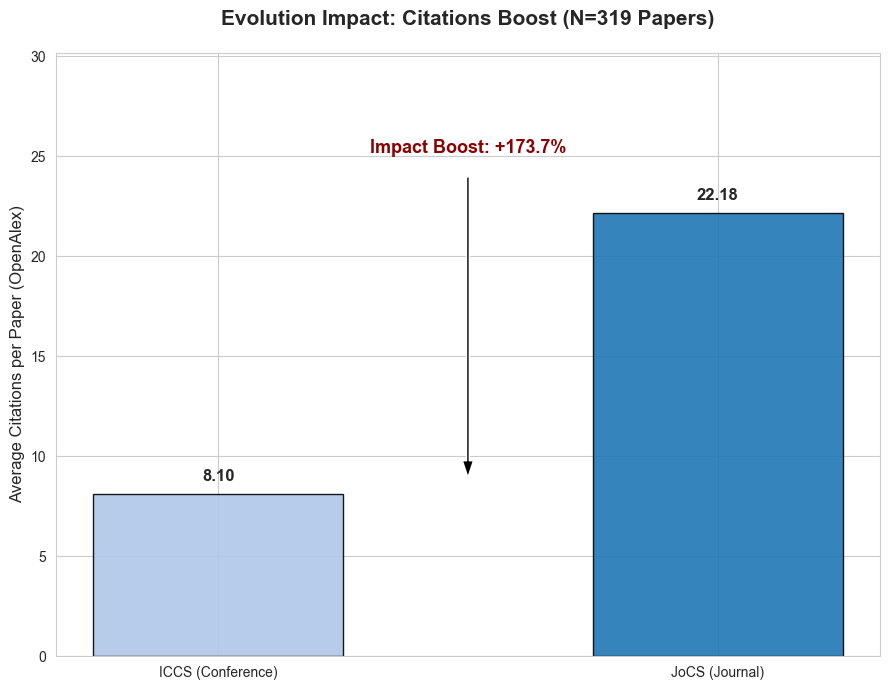

Plot finalized with 319 matched papers.
Verified Average -> ICCS: 8.10, JoCS: 22.18


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cell 2 mein jo merged data banaya tha usay use karein
# Is mein citations pehle hi DOI se accurately merge ho chuki hain
avg_iccs = evolution_with_citations['iccs_citations'].fillna(0).mean()
avg_jocs = evolution_with_citations['jocs_citations'].fillna(0).mean()

# 2. Plotting Logic
plt.figure(figsize=(9, 7))
sns.set_style("whitegrid")

labels = ['ICCS (Conference)', 'JoCS (Journal)']
values = [avg_iccs, avg_jocs]
colors = ['#aec7e8', '#1f77b4']

bars = plt.bar(labels, values, color=colors, width=0.5, edgecolor='black', alpha=0.9)

# Bars ke upar accurate values likhna
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# 3. Automatic Impact Boost Annotation
if avg_iccs > 0:
    boost_pct = ((avg_jocs - avg_iccs) / avg_iccs) * 100
    # Annotation ko data ke mutabiq adjust kiya hai taake tight_layout error na de
    plt.annotate(f'Impact Boost: +{boost_pct:.1f}%', 
                 xy=(0.5, avg_iccs), xytext=(0.5, avg_jocs + 3),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8),
                 ha='center', fontsize=13, fontweight='bold', color='darkred')

plt.title(f'Evolution Impact: Citations Boost (N={len(evolution_with_citations)} Papers)', 
          fontsize=15, fontweight='bold', pad=20)
plt.ylabel('Average Citations per Paper (OpenAlex)', fontsize=12)
plt.ylim(0, max(values) + 8) # Graph ke upar extra space

# Layout fix
plt.tight_layout()
plt.savefig("final_evolution_impact_boost.png", dpi=300)
plt.show()

print(f"Plot finalized with {len(evolution_with_citations)} matched papers.")
print(f"Verified Average -> ICCS: {avg_iccs:.2f}, JoCS: {avg_jocs:.2f}")

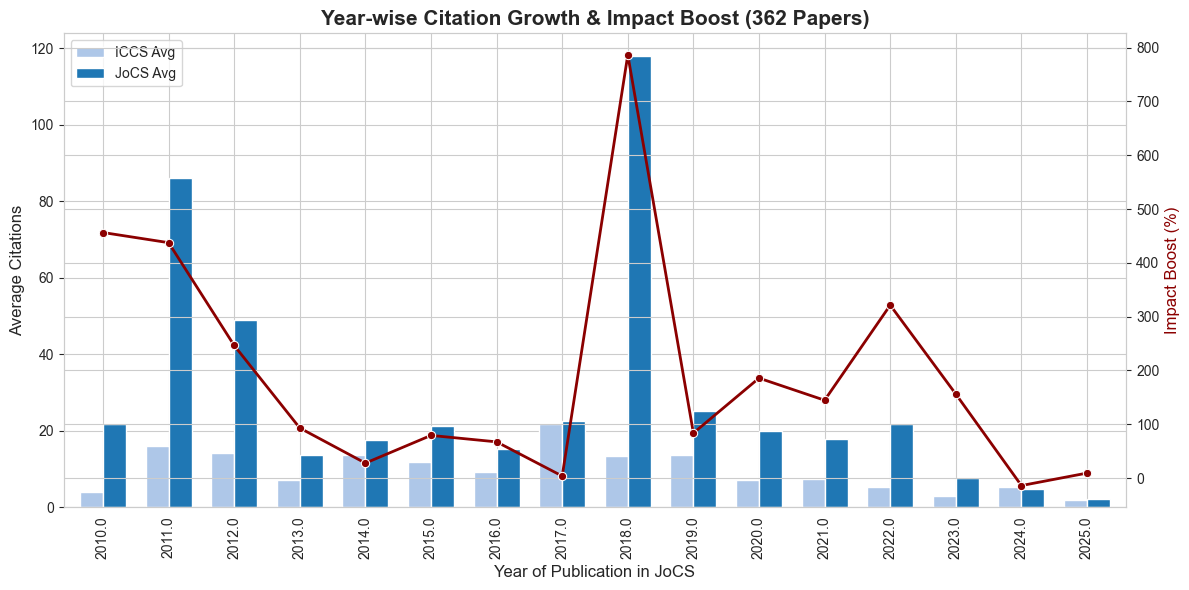

Yearly Boost Stats:
    jocs_year  boost_pct
0      2010.0     456.36
1      2011.0     437.50
2      2012.0     246.46
3      2013.0      92.98
4      2014.0      27.74
5      2015.0      79.22
6      2016.0      67.23
7      2017.0       3.69
8      2018.0     786.56
9      2019.0      83.52
10     2020.0     185.71
11     2021.0     144.61
12     2022.0     321.35
13     2023.0     156.04
14     2024.0     -14.00
15     2025.0       9.21


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Year-wise grouping aur averages calculate karein
# Hum 'jocs_year' use kar rahay hain kyunke ye journal publication ka saal hai
yearly_stats = evolution_with_citations.groupby('jocs_year')[['iccs_citations', 'jocs_citations']].mean().reset_index()

# 2. Year-wise Percentage Boost calculate karein
yearly_stats['boost_pct'] = ((yearly_stats['jocs_citations'] - yearly_stats['iccs_citations']) / yearly_stats['iccs_citations']) * 100

# 3. Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")

# Bar chart for citations
yearly_stats.plot(x='jocs_year', y=['iccs_citations', 'jocs_citations'], kind='bar', ax=ax1, color=['#aec7e8', '#1f77b4'], width=0.7)

# Line chart for Boost Percentage (on secondary axis)
ax2 = ax1.twinx()
sns.lineplot(data=yearly_stats, x=yearly_stats.index, y='boost_pct', ax=ax2, color='darkred', marker='o', linewidth=2, label='Boost %')

# Labels aur Title
ax1.set_title('Year-wise Citation Growth & Impact Boost (362 Papers)', fontsize=15, fontweight='bold')
ax1.set_xlabel('Year of Publication in JoCS', fontsize=12)
ax1.set_ylabel('Average Citations', fontsize=12)
ax2.set_ylabel('Impact Boost (%)', fontsize=12, color='darkred')

# Legend fix
ax1.legend(['ICCS Avg', 'JoCS Avg'], loc='upper left')
ax2.get_legend().remove()

plt.tight_layout()
plt.savefig("yearwise_boost_analysis.png", dpi=300)
plt.show()

print("Yearly Boost Stats:")
print(yearly_stats[['jocs_year', 'boost_pct']].round(2))

In [38]:
# Calculate the 95th percentile to identify top 5% outliers
outlier_threshold = evolution_with_citations['iccs_citations'].quantile(0.95)
outliers = evolution_with_citations[evolution_with_citations['iccs_citations'] > outlier_threshold]

print(f"Outlier Threshold (95th percentile): {outlier_threshold} citations")
print(f"Found {len(outliers)} major outliers in the 251 matched papers.")
print(outliers[['title', 'iccs_citations', 'jocs_citations']].sort_values(by='iccs_citations', ascending=False).head(10))

Outlier Threshold (95th percentile): 29.0 citations
Found 12 major outliers in the 251 matched papers.
                                                 title  iccs_citations  \
37   Optimization of Healthcare Emergency Departmen...             106   
98   Towards Understanding Uncertainty in Cloud Com...              94   
36   An Agent-Based Decision Support System for Hos...              86   
133  Improving Performance of Multiclass Classifica...              60   
106  Crack Detection in Earth Dam and Levee Passive...              55   
69   Discovering Multiple Diffusion Source Nodes in...              49   
6    Applying a Dynamic Data Driven Genetic Algorit...              46   
45   Quality credit evaluation based on TOPSIS: Evi...              38   
55   Multi-level CFD-based Airfoil Shape Optimizati...              36   
40   A Hybrid Simulation Model to Test Behaviour De...              33   

     jocs_citations  
37               39  
98              164  
36              

DOI Extraction from JOCS Special Issues txt files

In [39]:
import os
import re
import pandas as pd

# 1. Path where your txt files are stored
txt_folder = r"D:\ITMO Big Data & ML School\semester 3\RI3\special issues JOCS"
official_dois = []

# 2. Regex to find DOIs starting with 10.1016/j.jocs
# It looks for the pattern and stops at the end of the DOI string
doi_pattern = re.compile(r"10\.1016/j\.jocs\.[0-9a-zA-Z\.]+")

# 3. Loop through all files from 2014-2024
for filename in os.listdir(txt_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(txt_folder, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
            # Find all DOIs in the file
            found_dois = doi_pattern.findall(content)
            official_dois.extend([d.lower().strip('.') for d in found_dois])

# Create a clean DataFrame of official DOIs
df_official = pd.DataFrame({'official_doi': list(set(official_dois))})
print(f"Extracted {len(df_official)} unique DOIs from official Special Issue text files.")

# 4. Merge with your 251 AI matches (evolution_df)
# We use an 'outer' join to see the full picture
validation_results = pd.merge(
    evolution_df, 
    df_official, 
    left_on='jocs_doi', 
    right_on='official_doi', 
    how='outer', 
    indicator=True
)

# 5. Categorize for the Supervisor
def categorize(row):
    if row['_merge'] == 'both':
        return 'Confirmed Special Issue'
    elif row['_merge'] == 'left_only':
        return 'Organic/Informal Evolution'
    else:
        return 'Official SI (Missed by AI)'

validation_results['status'] = validation_results.apply(categorize, axis=1)

# 6. Save results
validation_results.to_csv("ai_vs_official_matching.csv", index=False)

# Summary Stats for Telegram
summary = validation_results['status'].value_counts()
print("\n--- Validation Summary ---")
print(summary)

Extracted 280 unique DOIs from official Special Issue text files.

--- Validation Summary ---
status
Confirmed Special Issue       187
Organic/Informal Evolution    132
Official SI (Missed by AI)    122
Name: count, dtype: int64
